### Further clean BALANCE variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.common import *
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, print_percentile,
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap, filter_df
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
START = time.time()

### Setup

In [7]:
%%time
train = read_file(f"../{RAW_DATA_PATH}/train_parquet_rounded/balance.parquet")
test = read_file(f"../{RAW_DATA_PATH}/test_parquet_rounded/balance.parquet")

Shape of data: (5531451, 45)
Shape of data: (11363762, 44)
CPU times: user 5.18 s, sys: 9.42 s, total: 14.6 s
Wall time: 14 s


In [8]:
# %%time
# labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
# if "target" not in train.columns:
#     train = train.merge(labels, on="customer_ID", how="left")

In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 3.24 s, sys: 3.55 s, total: 6.79 s
Wall time: 11.2 s


In [10]:
del test

In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 45), (5719469, 44), (5644293, 44))

In [12]:
df_list = [train, public_test, private_test]

In [13]:
balance_variables = get_cols(train, ["B_"])

In [14]:
print(sorted(balance_variables))

['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_2', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_3', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_4', 'B_40', 'B_41', 'B_42', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9']


In [15]:
# for df in df_list:
#     insert_row_number(df)

In [16]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
# train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_balance_corr.csv")
# train_corr.index = train_corr.columns

### Rounding

#### Round to 2 decimals

In [18]:
# # Skip some columns
# col_to_round = list(set(balance_variables) - set())

# %%time
# balance_variables_psi_list = []
# for col in tqdm(col_to_round):
#     pre_round = check_psi(df_list, col)[1]
#     df_list = round_dfs(df_list, col, decimals=2, add_new_col=False, nb_workers=8)
#     post_round = check_psi(df_list, col)[1]
#     balance_variables_psi_list.append((col, pre_round, post_round))

# balance_psi_df = pd.DataFrame(balance_variables_psi_list, columns=["feature", "psi_before", "psi_after"])

# sorted(balance_psi_df.loc[balance_psi_df["psi_before"] < balance_psi_df["psi_after"], "feature"].tolist())

# %%time
# train = df_list[0]
# test = pd.concat(df_list[1:], axis=0)
# test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)
# train.to_parquet(f"../{RAW_DATA_PATH}/train_parquet_rounded/balance.parquet")
# test.to_parquet(f"../{RAW_DATA_PATH}/test_parquet_rounded/balance.parquet")

### B_723 @Continuous, Increasing

In [19]:
for df in df_list:
    df["B_723"] = df["B_7"] + df["B_23"]
    df = clip_col(df, "B_723", top_value=2.62, add_new_col=False)
    df = clip_col(df, "B_723", btm_value=-0.03, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


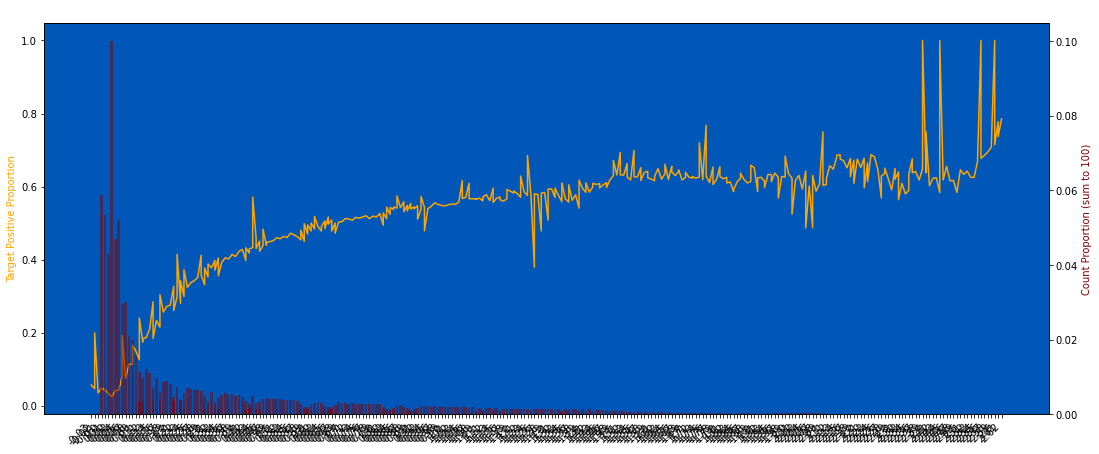

In [20]:
plot_target_check(train, "B_723", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [21]:
# print_percentile(df_list, "B_723", 0.005)
# describe_all(df_list, "B_723")

### B_111 @Continuous, n

In [22]:
for df in df_list:
    df["B_111"] = sigmoid(df["B_1"] / df["B_11"] - 1)

In [23]:
df_list = round_dfs(df_list, col="B_111", decimals=2, add_new_col=False)

In [24]:
for df in df_list:
    df = clip_col(df, "B_111", btm_value=0.26, add_new_col=False)

In [25]:
# print_percentile(df_list, "B_111", 0.5)

1568672 null count, 0.284 null proportion
0.0711 of the targets have label = 1


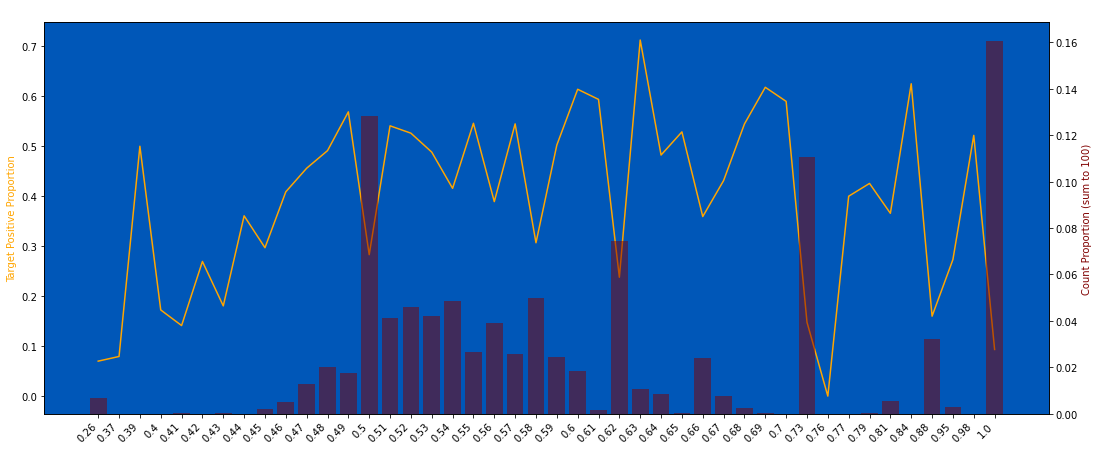

In [26]:
plot_target_check(train, "B_111", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [27]:
# plot_train_test_distribution(df_list, "B_111", nunique_thr=8000, without_drop_tail=True)

### B_137 @Continuous, n

In [28]:
for df in df_list:
    df["B_137"] = sigmoid(df["B_1"] / df["B_37"] - 1)

In [29]:
df_list = round_dfs(df_list, col="B_137", decimals=2, add_new_col=False)

In [30]:
for df in df_list:
    df = clip_col(df, "B_137", btm_value=0.26, add_new_col=False)
    df["B_137"] = df["B_137"].replace((1, 0.26), np.nan)

1725196 null count, 0.312 null proportion
0.0730 of the targets have label = 1


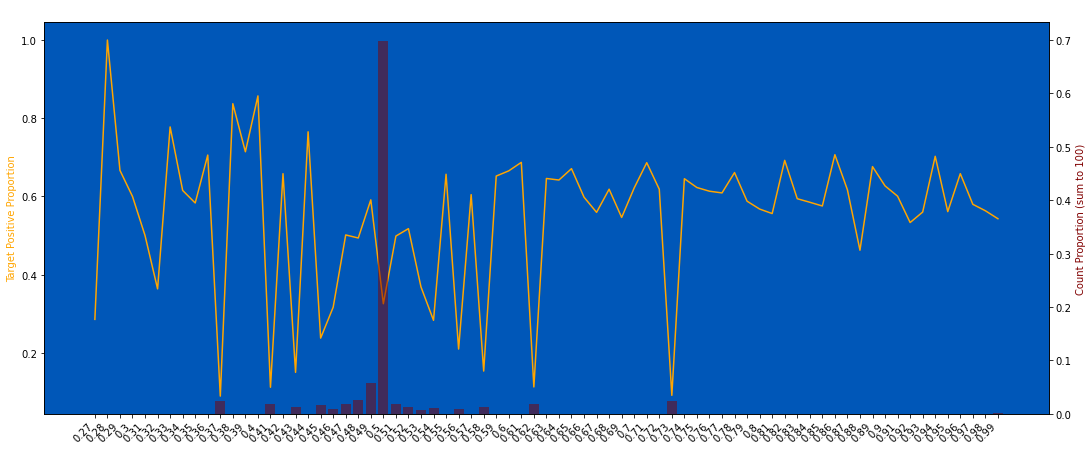

In [31]:
plot_target_check(train, "B_137", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [32]:
# plot_train_test_distribution(df_list, "B_137", nunique_thr=8000, without_drop_tail=True)

### B_1 @Continuous, Increasing

In [33]:
# plot_target_check(train, "B_1", q=50, use_raw_bin=True)

In [34]:
print_percentile(df_list, "B_1", 0.1)
# describe_all(df_list, "B_1")

0.1th percentile:
train : -0.01
public test : -0.01
private test : -0.02


In [35]:
for df in df_list:
    df = clip_col(df, "B_1", btm_value=-0.01, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


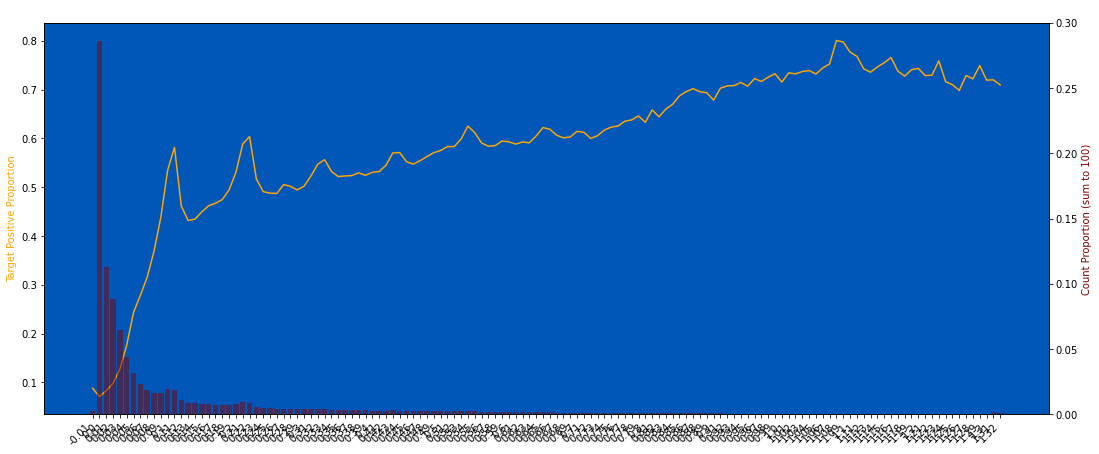

In [36]:
plot_target_check(train, "B_1", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [37]:
# plot_train_test_distribution(df_list, "B_1", nunique_thr=8000, without_drop_tail=True)

### B_2 @Continuous

In [38]:
# plot_target_check(train, "B_2", q=50, use_raw_bin=True)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


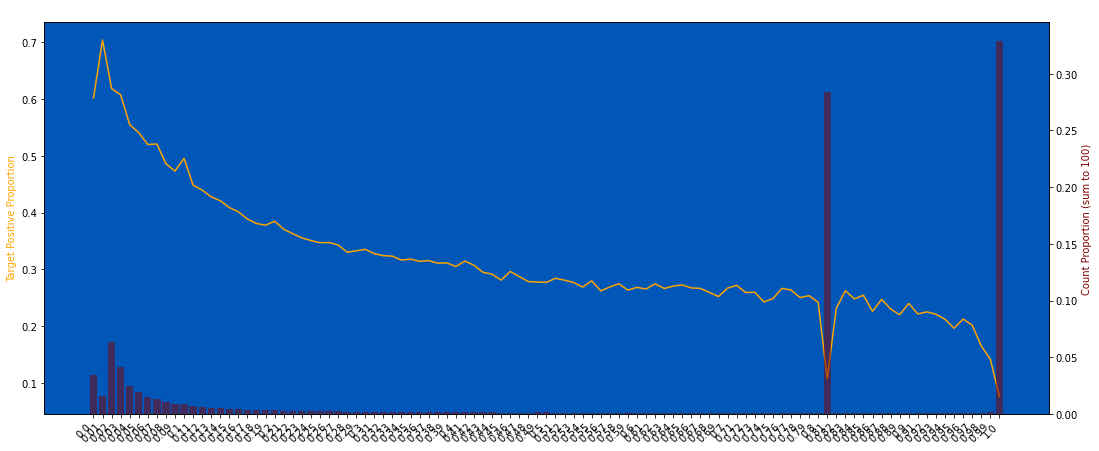

In [39]:
plot_target_check(train, "B_2", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [40]:
# plot_train_test_distribution(df_list, "B_2", nunique_thr=8000, without_drop_tail=True)

### B_3 @Continuous

In [41]:
# plot_target_check(train, "B_3", q=50, use_raw_bin=True)

In [42]:
for df in df_list:
    df = clip_col(df, "B_3", top_value=1.36, add_new_col=False)

In [43]:
print_percentile(df_list, "B_3", 99.99)
describe_all(df_list, "B_3")

99.99th percentile:
train : 1.36
public test : 1.36
private test : 1.36


,train,public test,private test
count,"5,529,435.0000","5,717,907.0000","5,642,938.0000"
mean,0.1275,0.1394,0.1374
std,0.2350,0.2459,0.2443
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0100,0.0100
75%,0.1500,0.1800,0.1700
max,1.3600,1.3600,1.3600
null_proportion,0.0004,0.0003,0.0002


2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


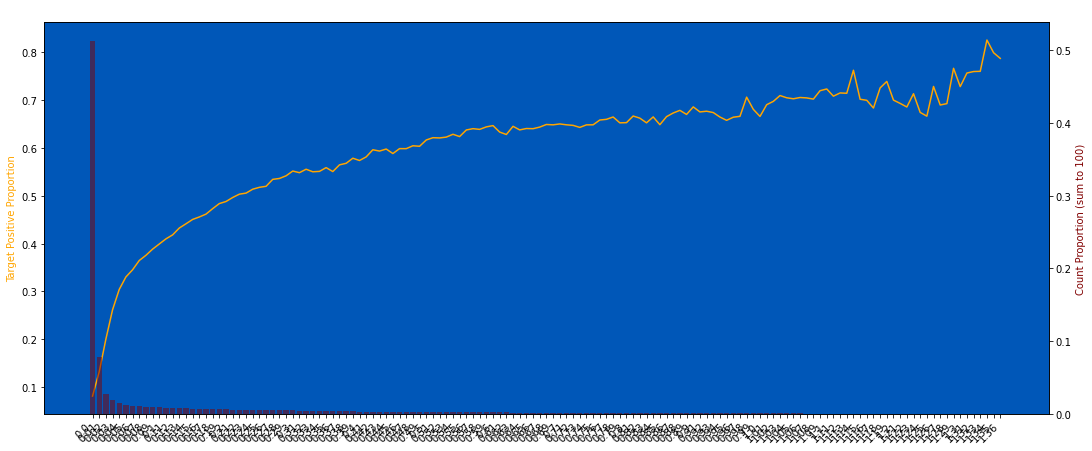

In [44]:
plot_target_check(train, "B_3", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True, without_drop_tail=True)

In [45]:
# plot_train_test_distribution(df_list, "B_3", nunique_thr=8000)

### B_4 @Continuous

In [46]:
# plot_target_check(train, "B_4", q=50, use_raw_bin=True, nunique_thr=1000)

In [47]:
# print_percentile(df_list, "B_4", 99.9)
# describe_all(df_list, "B_4")

In [48]:
for df in df_list:
    df = clip_col(df, "B_4", top_value=1.62, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


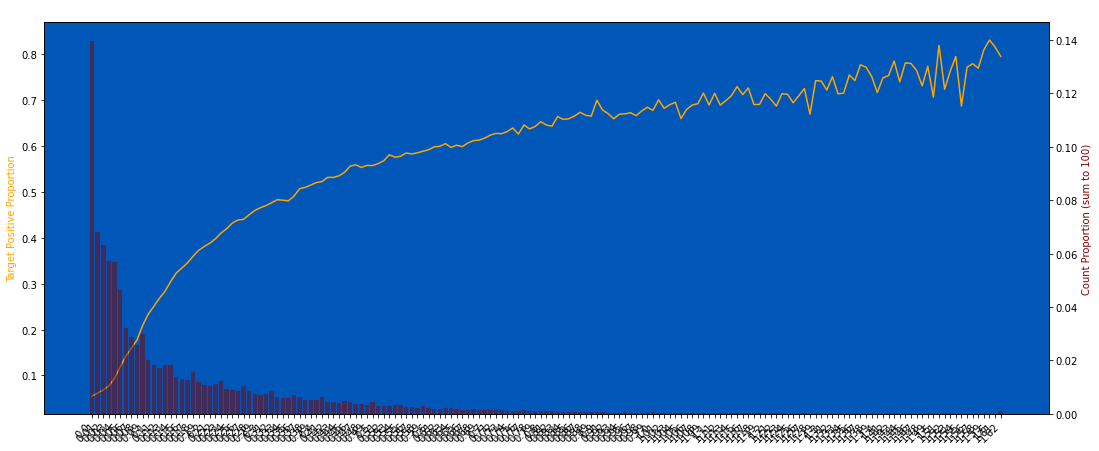

In [49]:
plot_target_check(train, "B_4", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

In [50]:
# plot_train_test_distribution(df_list, "B_4", nunique_thr=8000)

### B_5 @Continuous

In [51]:
# plot_target_check(train, "B_5", q=50, use_raw_bin=True)

In [52]:
print_percentile(df_list, "B_5", 99.7)
describe_all(df_list, "B_5")

99.7th percentile:
train : 2.01
public test : 2.12
private test : 2.25


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0781,0.0814,0.0871
std,0.3970,0.3901,0.3761
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0100,0.0100
75%,0.0500,0.0500,0.0600
max,144.2000,129.6300,72.8200
null_proportion,0.0000,0.0000,0.0000


In [53]:
for df in df_list:
    df = clip_col(df, "B_5", top_value=2.25, add_new_col=False)
    df["B_5"] = df["B_5"].replace(0, np.nan)

2108895 null count, 0.381 null proportion
0.2503 of the targets have label = 1


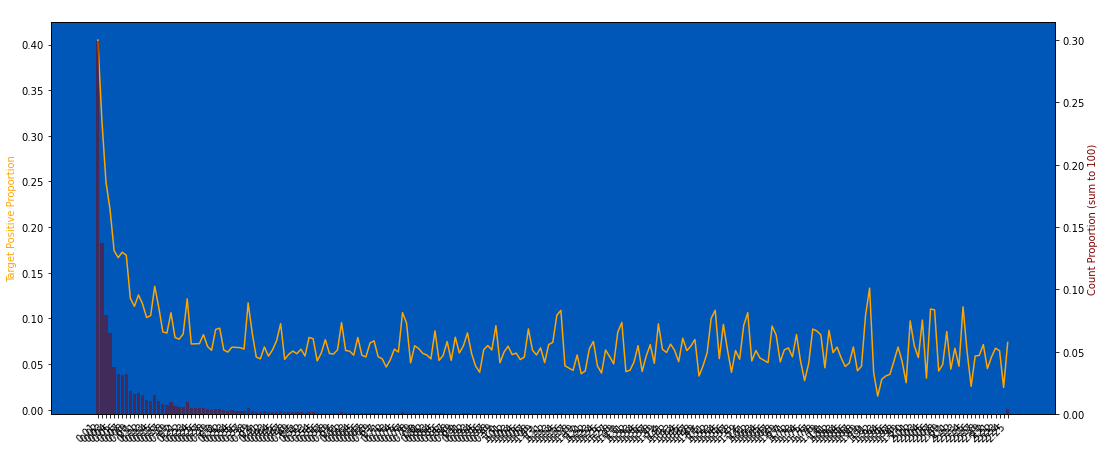

In [54]:
plot_target_check(train, "B_5", q=50, use_raw_bin=True, nunique_thr=8000, strfy_x=True)

In [55]:
# plot_train_test_distribution(df_list, "B_5", nunique_thr=8000)

### B_6 @Continuous

In [56]:
print_percentile(df_list, "B_6", 99.99)
describe_all(df_list, "B_6")

99.99th percentile:
train : 29.230263999924063
public test : 25.19
private test : 28.83


,train,public test,private test
count,"5,531,218.0000","5,717,778.0000","5,642,910.0000"
mean,0.1471,0.1477,0.1533
std,1.4768,0.7130,0.7427
min,-0.0100,-0.0100,-0.0100
25%,0.0200,0.0200,0.0200
50%,0.0800,0.0800,0.0800
75%,0.1900,0.1900,0.1900
max,"1,214.5100",191.8400,193.3800
null_proportion,0.0000,0.0003,0.0002


In [57]:
for df in df_list:
    df = clip_col(df, "B_6", top_value=30, add_new_col=False)

233 null count, 0.000 null proportion
0.2532 of the targets have label = 1
Top & Bottom 1% are dropped from this chart


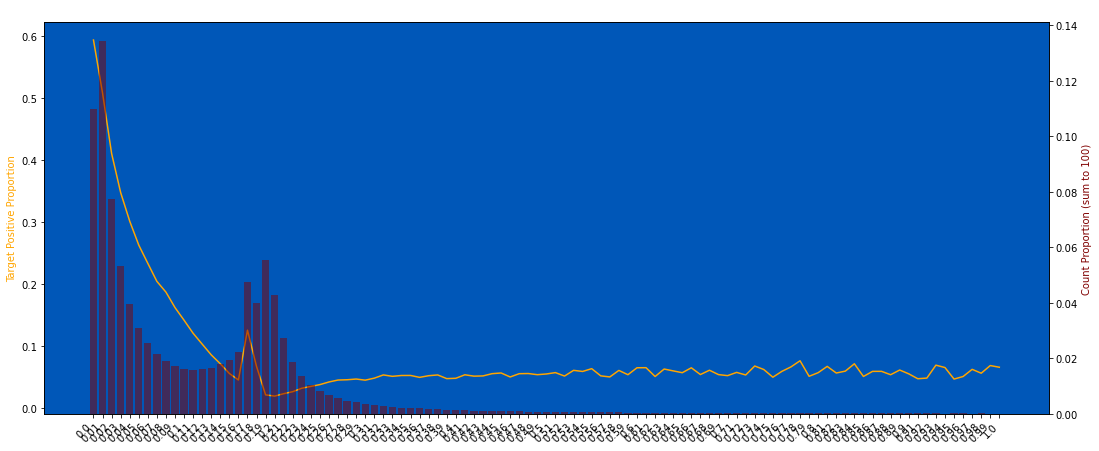

In [58]:
plot_target_check(train, "B_6", q=50, use_raw_bin=True, nunique_thr=7200, strfy_x=True, without_drop_tail=False)

In [59]:
# plot_train_test_distribution(df_list, "B_6", nunique_thr=8000)

### B_7 @Continuous

In [60]:
# plot_target_check(train, "B_7", q=50, use_raw_bin=True)

In [61]:
print_percentile(df_list, "B_7", 0.03)
describe_all(df_list, "B_7")

0.03th percentile:
train : -0.01
public test : -0.01
private test : -0.01


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1811,0.1805,0.1748
std,0.2304,0.2283,0.2248
min,-2.6600,-6.6800,-1.5600
25%,0.0200,0.0200,0.0200
50%,0.0700,0.0700,0.0700
75%,0.2700,0.2700,0.2600
max,1.2500,1.2500,1.2500
null_proportion,0.0000,0.0000,0.0000


In [62]:
for df in df_list:
    df = clip_col(df, "B_7", btm_value=-0.01, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


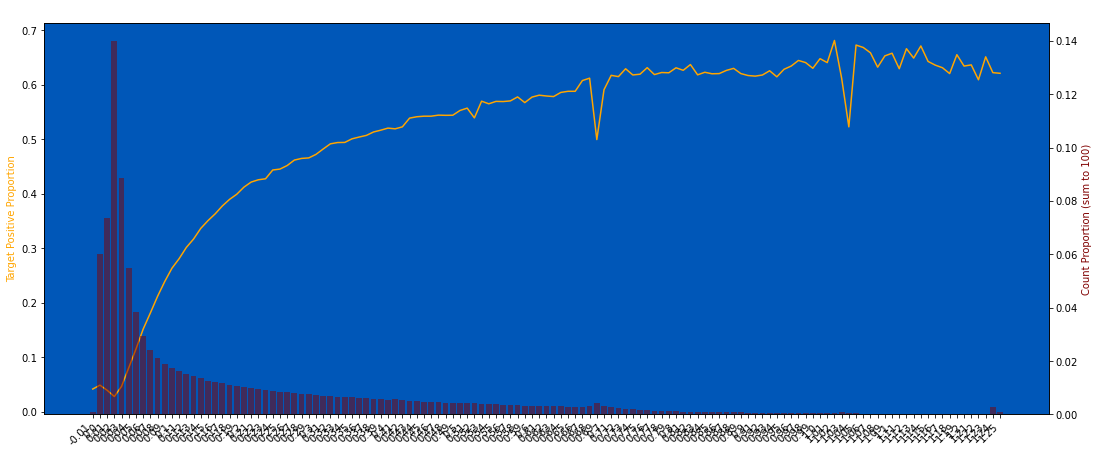

In [63]:
plot_target_check(train, "B_7", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [64]:
# plot_train_test_distribution(df_list, "B_7", nunique_thr=8000)

### B_8 @Binary

In [65]:
# plot_target_check(train, "B_8", q=50, use_raw_bin=True)

In [66]:
train["B_8"].value_counts()

0.0000    3053857
1.0000    2399757
0.9900      54735
1.0100        834
Name: B_8, dtype: int64

In [67]:
train.groupby(["B_8"])["target"].mean()

B_8
0.0000   0.1233
0.9900   0.3732
1.0000   0.4057
1.0100   0.6547
Name: target, dtype: float64

In [68]:
for df in df_list:
    df["B_8"] = df["B_8"].round(0)

22268 null count, 0.004 null proportion
0.3044 of the targets have label = 1


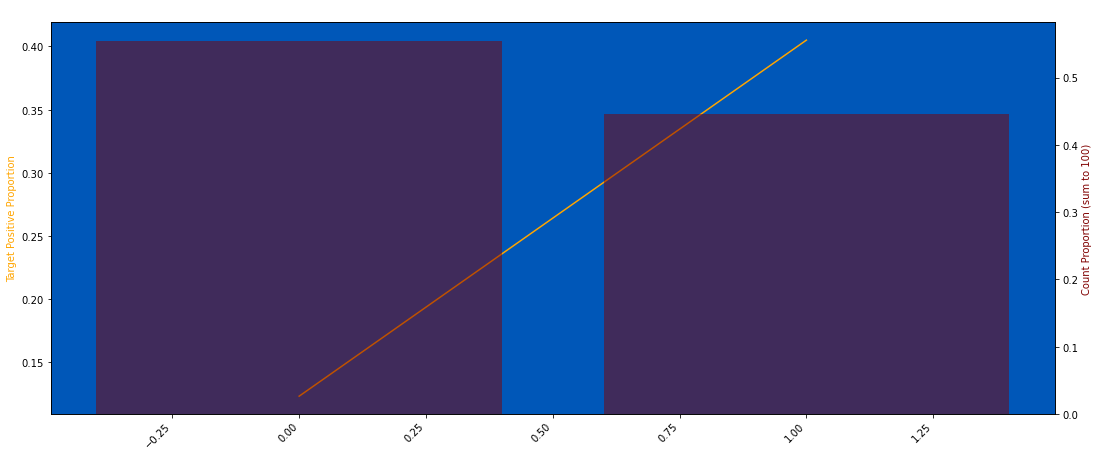

In [69]:
plot_target_check(train, "B_8", q=50, use_raw_bin=True)

In [70]:
# plot_train_test_distribution(df_list, "B_8", nunique_thr=8000)

### B_9 @Continuous

In [71]:
# plot_target_check(train, "B_9", q=50, use_raw_bin=True)

In [72]:
for df in df_list:
    df["B_9"] = df["B_9"].replace(0, np.nan)

In [73]:
print_percentile(df_list, "B_9", 99.99)
describe_all(df_list, "B_9")

99.99th percentile:
train : 6.234369999989868
public test : 5.8
private test : 6.094291999996639


,train,public test,private test
count,"3,067,816.0000","3,282,618.0000","3,255,709.0000"
mean,0.3327,0.3261,0.3120
std,0.3138,0.2985,0.2956
min,0.0100,0.0100,0.0100
25%,0.0700,0.0700,0.0600
50%,0.2800,0.2800,0.2500
75%,0.5800,0.5800,0.5700
max,27.4200,37.3700,90.6000
null_proportion,0.4454,0.4261,0.4232


In [74]:
for df in df_list:
    df = clip_col(df, "B_9", top_value=4.45, add_new_col=False)

2463635 null count, 0.445 null proportion
0.1038 of the targets have label = 1


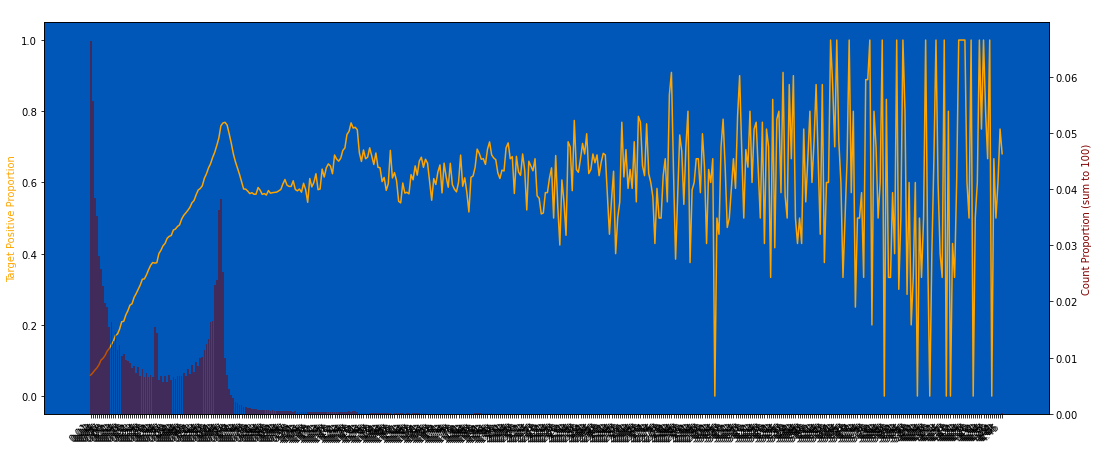

In [75]:
plot_target_check(train, "B_9", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True)

In [76]:
# plot_train_test_distribution(df_list, "B_9", nunique_thr=8000)

### B_10 @Continuous

In [77]:
# plot_target_check(train, "B_10", q=50, use_raw_bin=True)

In [78]:
print_percentile(df_list, "B_10", 99.99)
describe_all(df_list, "B_10")

99.99th percentile:
train : 96.16734999972395
public test : 112.92212799996138
private test : 118.93


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.2266,0.2412,0.2550
std,4.7998,5.3091,5.7670
min,-0.0100,-0.0100,-0.0100
25%,0.0200,0.0200,0.0200
50%,0.1100,0.1100,0.1200
75%,0.2900,0.2900,0.2900
max,"4,097.4400","4,660.3500","4,345.8500"
null_proportion,0.0000,0.0000,0.0000


In [79]:
for df in df_list:
    df = clip_col(df, "B_10", top_value=100, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1
Top & Bottom 1% are dropped from this chart


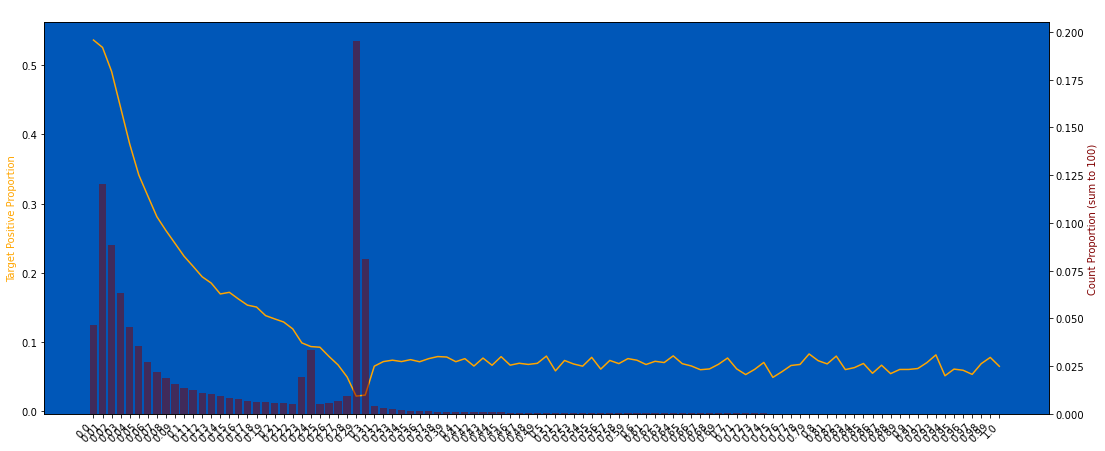

In [80]:
plot_target_check(train, "B_10", q=50, use_raw_bin=True, nunique_thr=7000, strfy_x=True, without_drop_tail=False)

In [81]:
# plot_train_test_distribution(df_list, "B_10", nunique_thr=8000)

### B_11 @Continuous, Increasing

In [82]:
# plot_target_check(train, "B_11", q=50, use_raw_bin=True)

In [83]:
print_percentile(df_list, "B_11", 99.9)
describe_all(df_list, "B_11")

99.9th percentile:
train : 1.36
public test : 1.36
private test : 1.36


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1060,0.1122,0.1080
std,0.2083,0.2127,0.2065
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0200,0.0200
75%,0.1000,0.1100,0.1000
max,1.9700,1.8500,1.9400
null_proportion,0.0000,0.0000,0.0000


In [84]:
for df in df_list:
    df = clip_col(df, "B_11", top_value=1.36, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


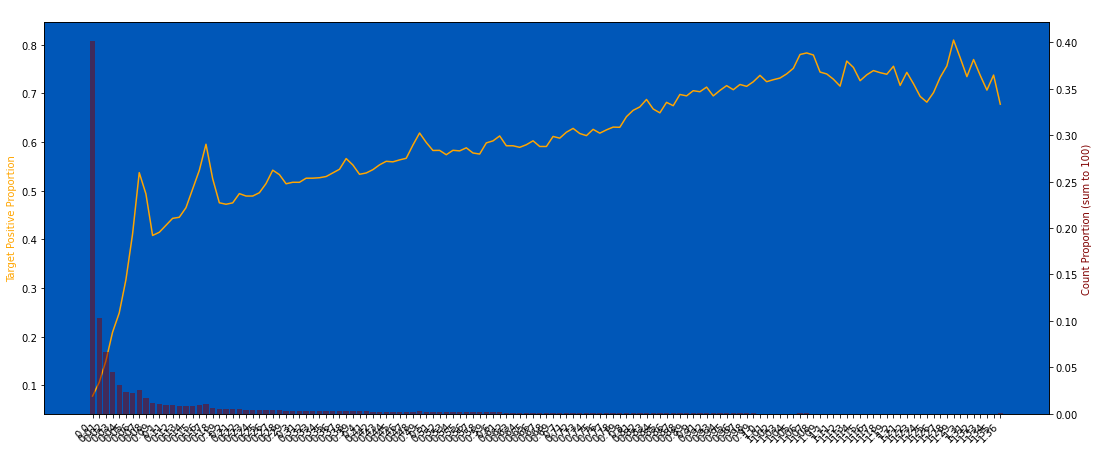

In [85]:
plot_target_check(train, "B_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [86]:
# plot_train_test_distribution(df_list, "B_11", nunique_thr=8000)

### B_12 @Continuous, Decreasing

In [87]:
# plot_target_check(train, "B_12", q=50, use_raw_bin=True)

In [88]:
print_percentile(df_list, "B_12", 99.9)
describe_all(df_list, "B_12")

99.9th percentile:
train : 4.81
public test : 5.16
private test : 5.7


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0887,0.0948,0.1030
std,0.8204,0.5928,0.6029
min,0.0000,0.0000,0.0000
25%,0.0100,0.0100,0.0100
50%,0.0100,0.0200,0.0200
75%,0.0600,0.0700,0.0800
max,420.7400,192.6800,205.2900
null_proportion,0.0000,0.0000,0.0000


In [89]:
for df in df_list:
    df = clip_col(df, "B_12", top_value=5, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


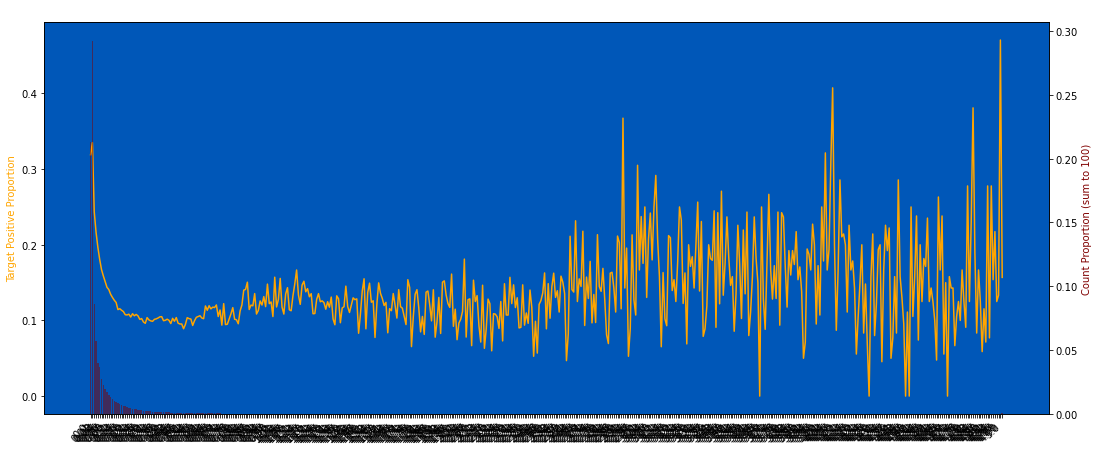

In [90]:
plot_target_check(train, "B_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [91]:
# plot_train_test_distribution(df_list, "B_12", nunique_thr=8000)

### B_13 @Continuous, Decreasing

In [92]:
# plot_target_check(train, "B_13", q=50, use_raw_bin=True)

In [93]:
print_percentile(df_list, "B_13", 99.9)
describe_all(df_list, "B_13")

99.9th percentile:
train : 4.47
public test : 4.67
private test : 5.13


,train,public test,private test
count,"5,481,932.0000","5,685,813.0000","5,619,491.0000"
mean,0.0957,0.1026,0.1091
std,0.5594,0.5719,0.5029
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0100
50%,0.0200,0.0300,0.0300
75%,0.0800,0.0900,0.1000
max,276.1700,261.5500,143.1100
null_proportion,0.0090,0.0059,0.0044


In [94]:
for df in df_list:
    df = clip_col(df, "B_13", top_value=5, add_new_col=False)

49519 null count, 0.009 null proportion
0.4906 of the targets have label = 1


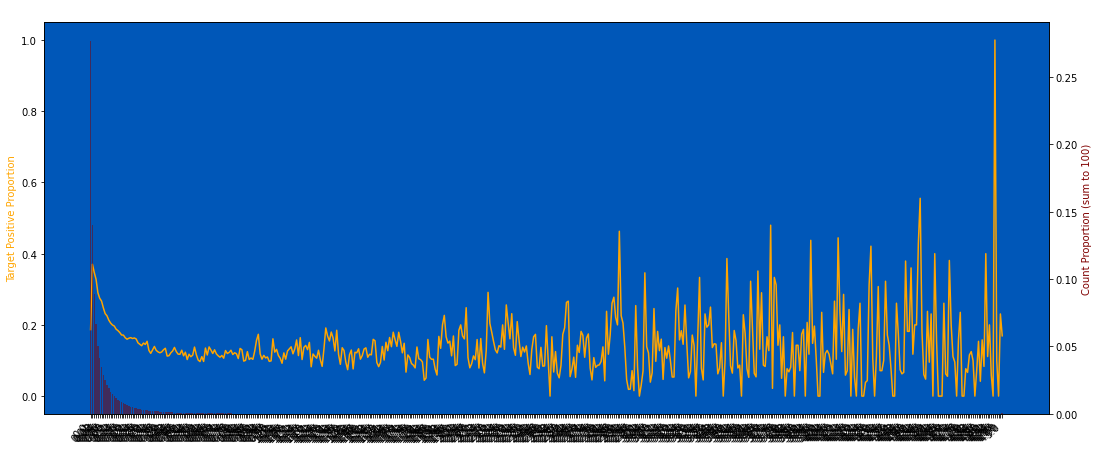

In [95]:
plot_target_check(train, "B_13", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [96]:
# plot_train_test_distribution(df_list, "B_13", nunique_thr=8000)

### B_14 @Continuous, Decreasing

In [97]:
# plot_target_check(train, "B_14", q=50, use_raw_bin=True)

In [98]:
print_percentile(df_list, "B_14", 99.9)
describe_all(df_list, "B_14")

99.9th percentile:
train : 2.83
public test : 2.9
private test : 3.14


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0962,0.1041,0.1073
std,0.2836,0.2831,0.2903
min,-8.4700,-18.0000,-32.2300
25%,0.0000,0.0000,0.0000
50%,0.0200,0.0300,0.0300
75%,0.1000,0.1100,0.1100
max,55.0100,60.2300,32.4200
null_proportion,0.0000,0.0000,0.0000


In [99]:
for df in df_list:
    df = clip_col(df, "B_14", btm_value=-0.15, add_new_col=False)
    df = clip_col(df, "B_14", top_value=5, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


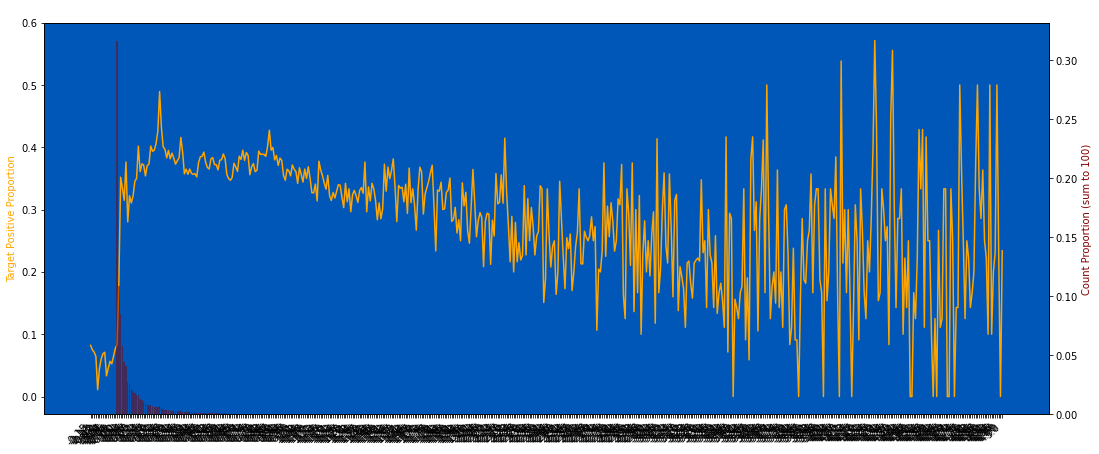

In [100]:
plot_target_check(train, "B_14", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [101]:
# plot_train_test_distribution(df_list, "B_14", nunique_thr=8000, without_drop_tail=True)

### B_15 @Continuous, Increasing

In [102]:
# plot_target_check(train, "B_15", q=50, use_raw_bin=True)

In [103]:
print_percentile(df_list, "B_15", 0.5)
describe_all(df_list, "B_15")

0.5th percentile:
train : 0.0
public test : 0.0
private test : 0.0


,train,public test,private test
count,"5,524,528.0000","5,710,673.0000","5,638,316.0000"
mean,0.0478,0.0492,0.0520
std,0.3005,0.2956,0.3021
min,-10.0100,-21.2800,-38.1000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,65.0300,71.2100,38.3300
null_proportion,0.0013,0.0015,0.0011


In [104]:
for df in df_list:
    df = clip_col(df, "B_15", btm_value=-0.5, add_new_col=False)
    df = clip_col(df, "B_15", top_value=1.5, add_new_col=False)

6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1


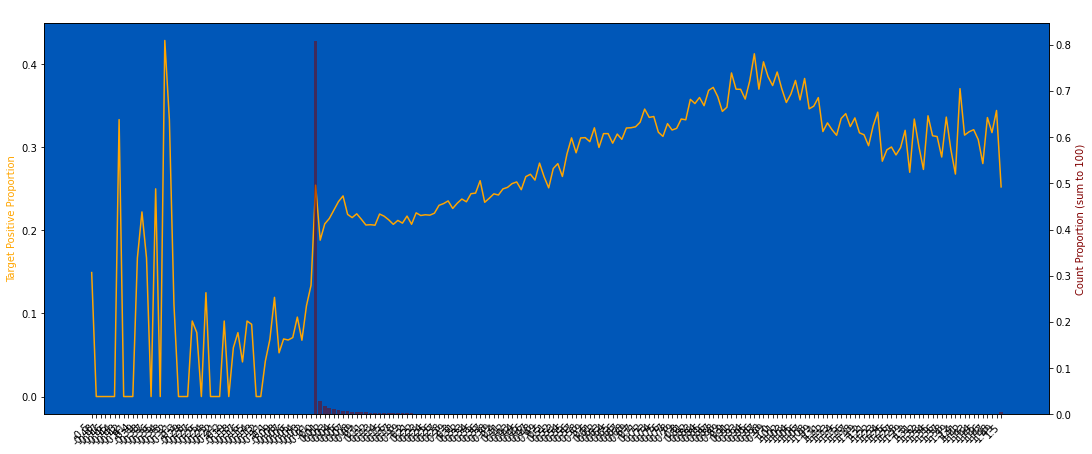

In [105]:
plot_target_check(train, "B_15", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

In [106]:
# plot_train_test_distribution(df_list, "B_15", nunique_thr=8000, without_drop_tail=True)

### B_16 @Integer, Increasing

In [107]:
# plot_target_check(train, "B_16", q=50, use_raw_bin=True)

In [108]:
for df in df_list:
    df["B_16"] = (df["B_16"] / 0.083).round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


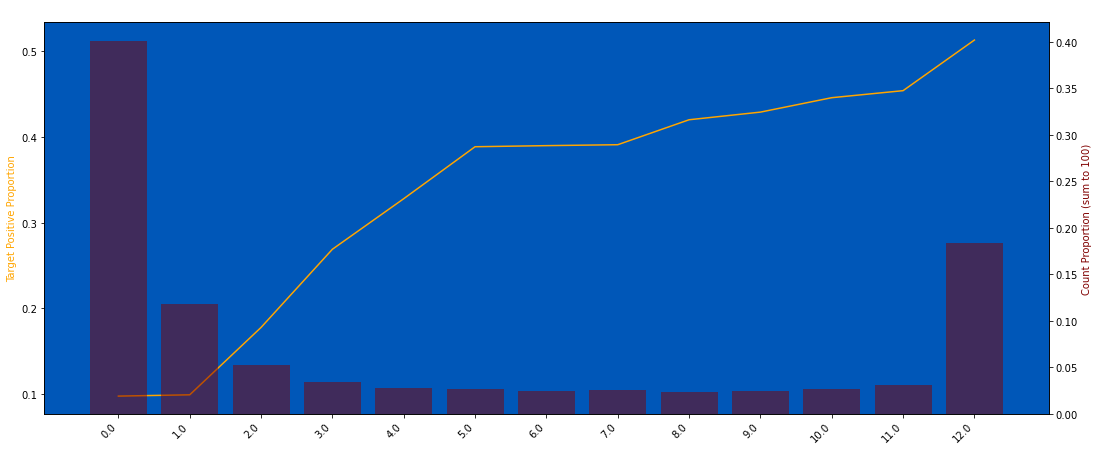

In [109]:
plot_target_check(train, "B_16", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

In [110]:
# plot_train_test_distribution(df_list, "B_16", nunique_thr=8000)

### B_17 @Continuous, Increasing

In [111]:
# plot_target_check(train, "B_17", q=50, use_raw_bin=True)

3137598 null count, 0.567 null proportion
0.1226 of the targets have label = 1


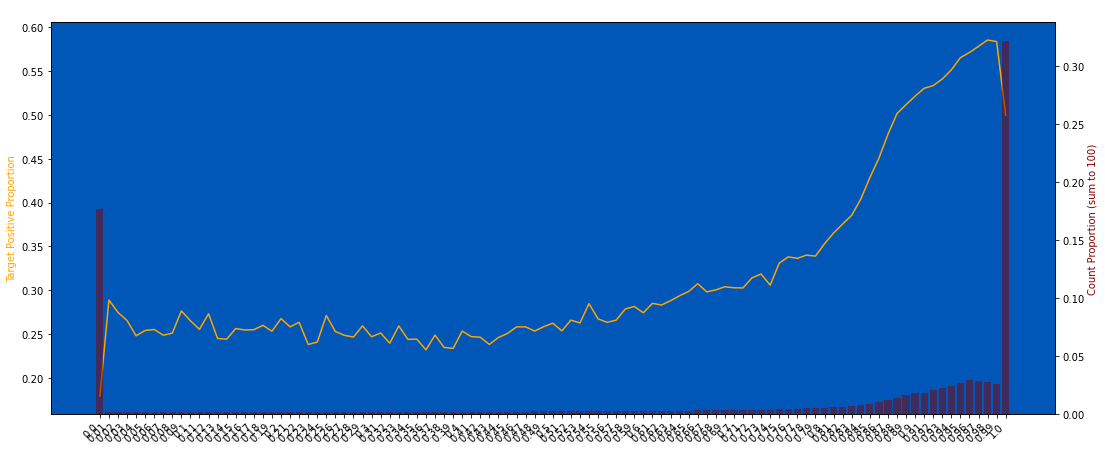

In [112]:
plot_target_check(train, "B_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [113]:
# plot_train_test_distribution(df_list, "B_17", nunique_thr=8000)

### B_18 @Integer, Decreasing

In [114]:
# plot_target_check(train, "B_18", q=50, use_raw_bin=True)

In [115]:
for df in df_list:
    df["B_18"] = (df["B_18"] / 0.05).round(0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


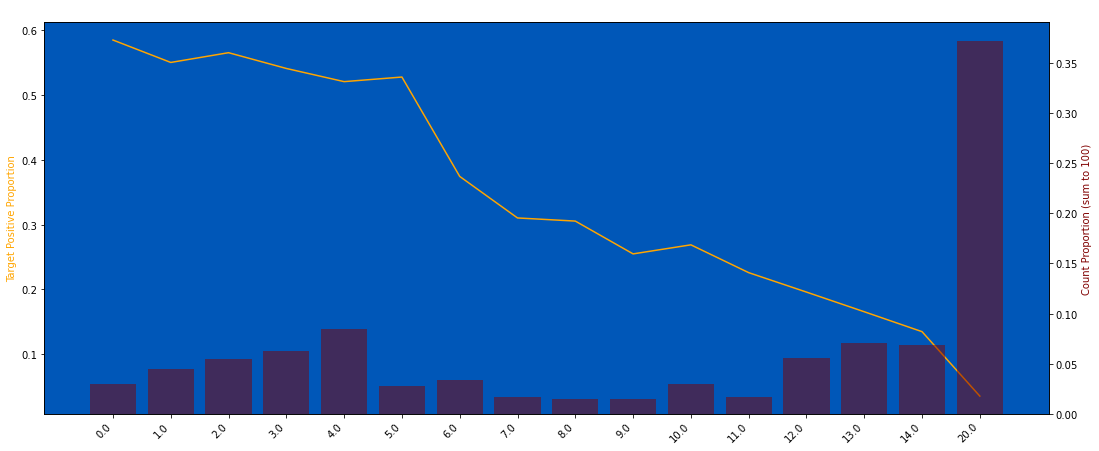

In [116]:
plot_target_check(train, "B_18", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [117]:
# plot_train_test_distribution(df_list, "B_18", nunique_thr=8000)

### B_19 @Integer, Increasing

In [118]:
# plot_target_check(train, "B_19", q=50, use_raw_bin=True)

In [119]:
# plot_target_check(train, "B_19", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [120]:
for df in df_list:
    df["B_19"] = (df["B_19"] / 0.0799)
df_list = round_dfs(df_list, col="B_19", decimals=0, add_new_col=False)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


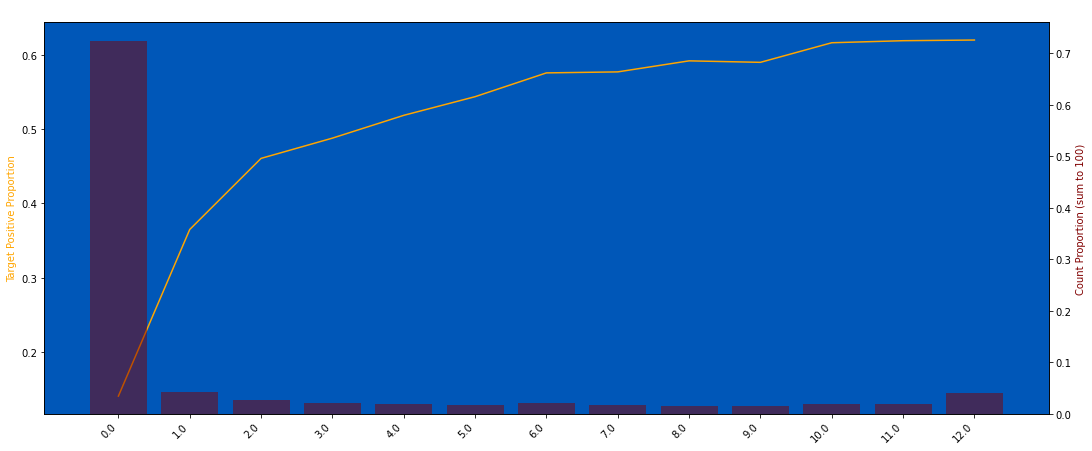

In [121]:
plot_target_check(train, "B_19", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [122]:
# plot_train_test_distribution(df_list, "B_19", nunique_thr=8000)

### B_20 @Integer, Increasing

In [123]:
# plot_target_check(train, "B_20", q=50, use_raw_bin=True)

In [124]:
# plot_target_check(train, "B_20", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [125]:
for df in df_list:
    df["B_20"] = (df["B_20"] / 0.06).round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


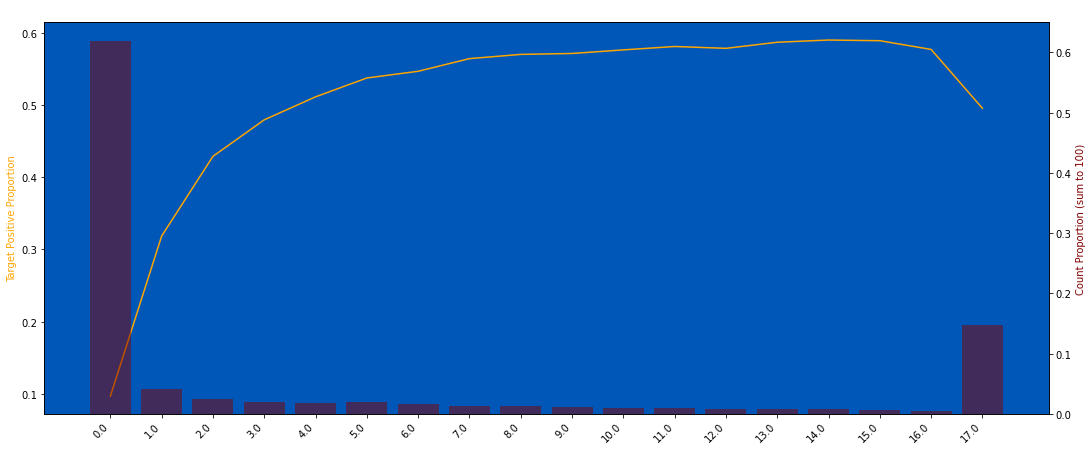

In [126]:
plot_target_check(train, "B_20", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [127]:
# plot_train_test_distribution(df_list, "B_20", nunique_thr=8000)

### B_21 @Continuous, Increasing

In [128]:
# plot_target_check(train, "B_21", q=50, use_raw_bin=True)

In [129]:
for df in df_list:
    df["B_21"] = ((df["B_21"] - 0.01) / 0.1)
df_list = round_dfs(df_list, col="B_21", decimals=0, add_new_col=False)

In [130]:
for df in df_list:
    df["B_21"] = df["B_21"].replace(-1, np.nan)

In [131]:
print_percentile(df_list, "B_21", 99.9)
describe_all(df_list, "B_21")

99.9th percentile:
train : 482.4120000000112
public test : 425.1590000000142
private test : 523.1570000000356


,train,public test,private test
count,"111,795.0000","106,842.0000","94,282.0000"
mean,23.2104,21.7444,21.0802
std,44.8041,43.8587,45.5407
min,0.0000,0.0000,0.0000
25%,3.0000,2.0000,2.0000
50%,9.0000,9.0000,8.0000
75%,25.0000,24.0000,22.0000
max,"2,882.0000","2,002.0000","2,112.0000"
null_proportion,0.9798,0.9813,0.9833


In [132]:
for df in df_list:
    df = clip_col(df, "B_21", top_value=200, add_new_col=False)

5419656 null count, 0.980 null proportion
0.2390 of the targets have label = 1


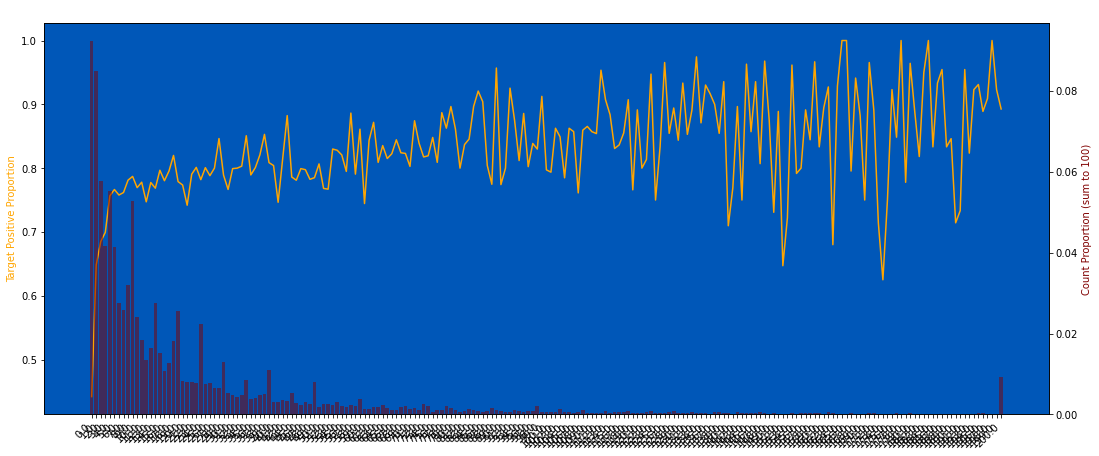

In [133]:
plot_target_check(train, "B_21", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [134]:
# plot_train_test_distribution(df_list, "B_21", nunique_thr=8000)

### B_22 @Integer, Increasing

In [135]:
# plot_target_check(train, "B_22", q=50, use_raw_bin=True, nunique_thr=7000)

In [136]:
for df in df_list:
    df["B_22"] *= 2

In [137]:
print_percentile(df_list, "B_22", 99.99)
describe_all(df_list, "B_22")

99.99th percentile:
train : 4.0
public test : 4.0
private test : 4.0


,train,public test,private test
count,"5,529,435.0000","5,717,907.0000","5,642,938.0000"
mean,0.2045,0.2180,0.2122
std,0.4465,0.4623,0.4577
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,7.0000,7.0000,8.0000
null_proportion,0.0004,0.0003,0.0002


In [138]:
for df in df_list:
    df = clip_col(df, "B_22", top_value=4, add_new_col=False)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


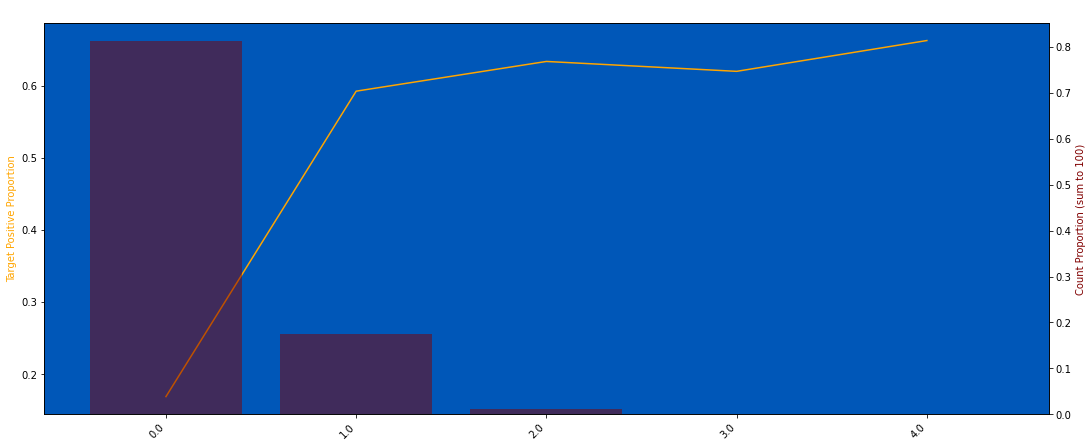

In [139]:
plot_target_check(train, "B_22", q=50, use_raw_bin=True, nunique_thr=7000, strfy_x=True, without_drop_tail=True)

In [140]:
# plot_train_test_distribution(df_list, "B_22", nunique_thr=8000, without_drop_tail=True)

### B_23 @Continuous, Increasing

In [141]:
# plot_target_check(train, "B_23", q=50, use_raw_bin=True)

In [142]:
print_percentile(df_list, "B_23", 99.99)
describe_all(df_list, "B_23")

99.99th percentile:
train : 1.38
public test : 1.37
private test : 1.37


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1665,0.1666,0.1613
std,0.2294,0.2276,0.2244
min,0.0000,0.0000,0.0000
25%,0.0100,0.0100,0.0100
50%,0.0500,0.0600,0.0500
75%,0.2400,0.2400,0.2300
max,1.6900,1.5900,1.6700
null_proportion,0.0000,0.0000,0.0000


In [143]:
for df in df_list:
    df = clip_col(df, "B_23", top_value=1.37, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


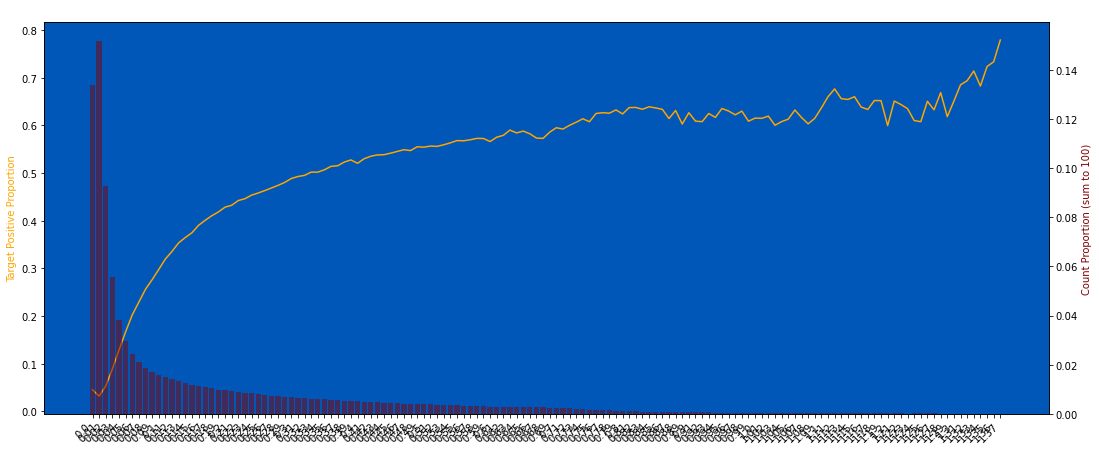

In [144]:
plot_target_check(train, "B_23", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [145]:
# plot_train_test_distribution(df_list, "B_23", nunique_thr=5000, without_drop_tail=True)

### B_24 @Continuous, Increasing

In [146]:
# plot_target_check(train, "B_24", q=50, use_raw_bin=True)

In [147]:
for df in df_list:
    df["B_24"] = (df["B_24"] / 0.05).round(0)
    df["B_24"] = df["B_24"].replace(0, np.nan)

In [148]:
print_percentile(df_list, "B_24", 99.9)
describe_all(df_list, "B_24")

99.9th percentile:
train : 264.0
public test : 295.0590000000375
private test : 279.0


,train,public test,private test
count,"187,235.0000","218,942.0000","220,727.0000"
mean,20.4767,21.7314,21.8214
std,28.0004,30.4286,29.5900
min,1.0000,1.0000,1.0000
25%,7.0000,7.0000,7.0000
50%,12.0000,12.0000,12.0000
75%,23.0000,24.0000,25.0000
max,932.0000,"1,474.0000",879.0000
null_proportion,0.9662,0.9617,0.9609


In [149]:
for df in df_list:
    df = clip_col(df, "B_24", top_value=200, add_new_col=False)

5344216 null count, 0.966 null proportion
0.2381 of the targets have label = 1


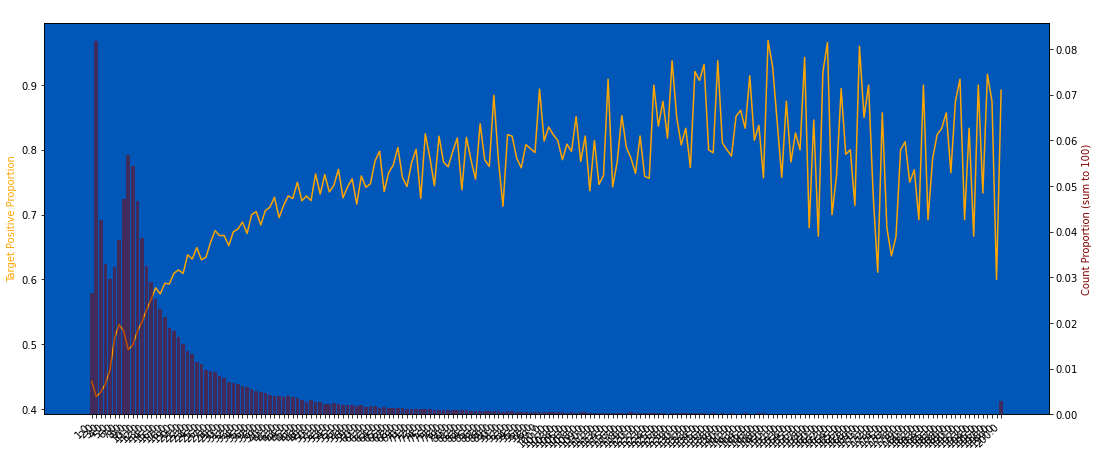

In [150]:
plot_target_check(train, "B_24", q=200, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [151]:
# plot_train_test_distribution(df_list, "B_24", nunique_thr=8000)

### B_25 @Continuous, Increasing

In [152]:
# plot_target_check(train, "B_25", q=50, use_raw_bin=True)

In [153]:
print_percentile(df_list, "B_25", 0.1)
describe_all(df_list, "B_25")

0.1th percentile:
train : -0.01
public test : -0.02
private test : -0.02


,train,public test,private test
count,"5,524,528.0000","5,710,673.0000","5,638,316.0000"
mean,0.0989,0.1108,0.1122
std,0.2087,0.2249,0.2304
min,-11.2600,-4.7500,-4.2700
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0200,0.0200
75%,0.1000,0.1200,0.1200
max,15.6900,21.6400,41.7000
null_proportion,0.0013,0.0015,0.0011


In [154]:
for df in df_list:
    df = clip_col(df, "B_25", top_value=2, add_new_col=False)
    df = clip_col(df, "B_25", btm_value=-0.1, add_new_col=False)

6923 null count, 0.001 null proportion
0.0858 of the targets have label = 1


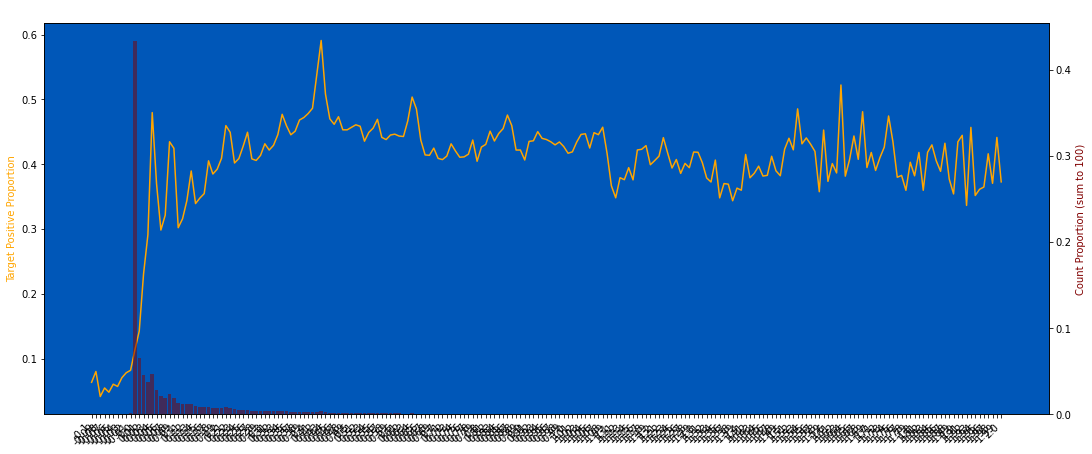

In [155]:
plot_target_check(train, "B_25", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [156]:
# plot_train_test_distribution(df_list, "B_25", nunique_thr=8000)

### B_26 @Continuous, Decreasing

In [157]:
# plot_target_check(train, "B_26", q=50, use_raw_bin=True)

In [158]:
for df in df_list:
    df["B_26"] = df["B_26"].replace(0, np.nan)

In [159]:
print_percentile(df_list, "B_26", 95)
describe_all(df_list, "B_26")

95th percentile:
train : 7.0
public test : 6.62
private test : 7.48


,train,public test,private test
count,"250,153.0000","250,613.0000","245,415.0000"
mean,1.8926,1.8318,2.0300
std,12.0272,10.4051,11.2642
min,0.0100,0.0100,0.0100
25%,0.0700,0.0700,0.0700
50%,0.2000,0.2000,0.2100
75%,0.7900,0.7500,0.8300
max,"1,499.2200","1,033.2500",772.7400
null_proportion,0.9548,0.9562,0.9565


In [160]:
for df in df_list:
    df = clip_col(df, "B_26", top_value=7.5, add_new_col=False)
    # df["B_26"] = df["B_26"].replace(0.01, np.nan)

5281298 null count, 0.955 null proportion
0.2316 of the targets have label = 1


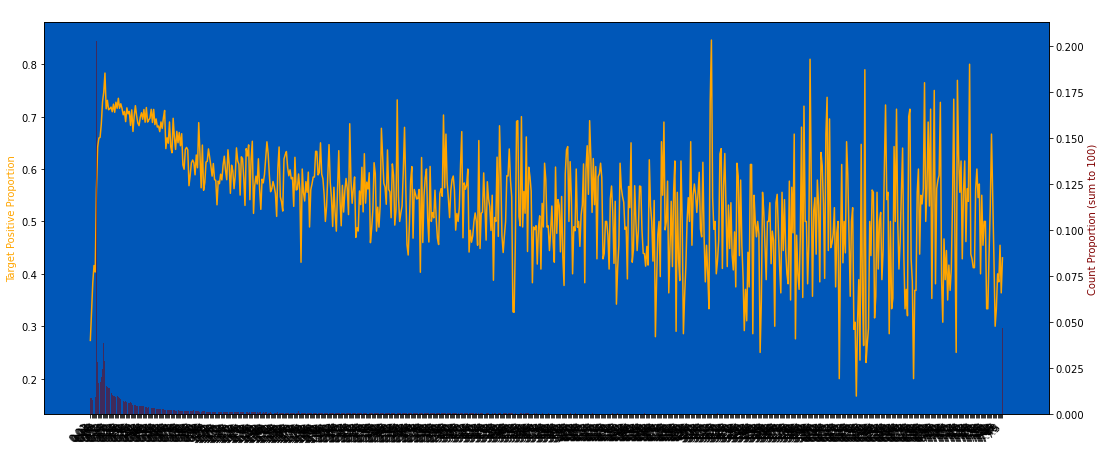

In [161]:
plot_target_check(train, "B_26", q=100, use_raw_bin=True, nunique_thr=35000, strfy_x=True, without_drop_tail=True)

In [162]:
# plot_train_test_distribution(df_list, "B_26", nunique_thr=8000, without_drop_tail=True)

### B_27 @Binary, Increasing

In [163]:
# plot_target_check(train, "B_27", q=50, use_raw_bin=True)

In [164]:
# plot_target_check(train, "B_27", q=500, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [165]:
for df in df_list:
    df["B_27"] = np.where(df["B_27"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


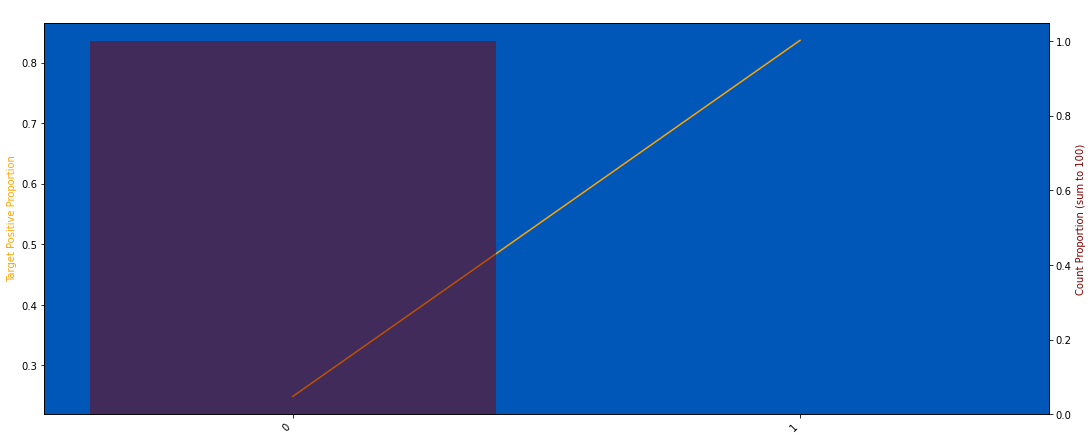

In [166]:
plot_target_check(train, "B_27", q=500, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [167]:
# plot_train_test_distribution(df_list, "B_27", nunique_thr=8000, without_drop_tail=True)

### B_28 @Continuous, Increasing

In [168]:
# plot_target_check(train, "B_28", q=50, use_raw_bin=True)

In [169]:
print_percentile(df_list, "B_28", 99.95)
describe_all(df_list, "B_28")

99.95th percentile:
train : 2.45
public test : 2.52
private test : 2.62


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.1495,0.1567,0.1578
std,0.2275,0.2318,0.2349
min,-0.0100,-0.0100,-0.0100
25%,0.0200,0.0200,0.0200
50%,0.0700,0.0800,0.0800
75%,0.1900,0.2000,0.2000
max,25.5300,28.0200,15.1700
null_proportion,0.0000,0.0000,0.0000


In [170]:
for df in df_list:
    df = clip_col(df, "B_28", top_value=2.5, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


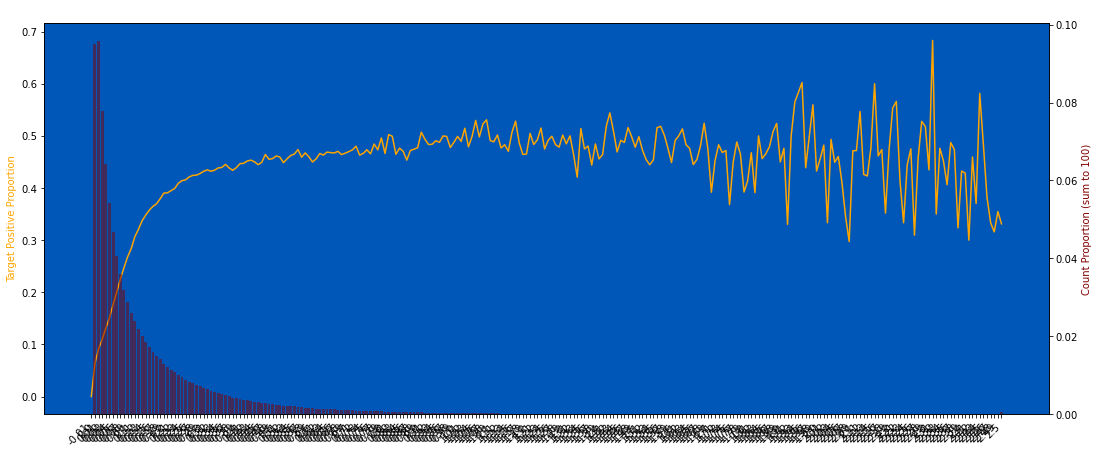

In [171]:
plot_target_check(train, "B_28", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [172]:
# plot_train_test_distribution(df_list, "B_28", nunique_thr=8000, without_drop_tail=True)

### B_29 (Drop due to null count drift)

In [173]:
for df in df_list:
    df.drop(columns="B_29", errors="ignore", inplace=True)

### B_30 @Category, Increasing

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


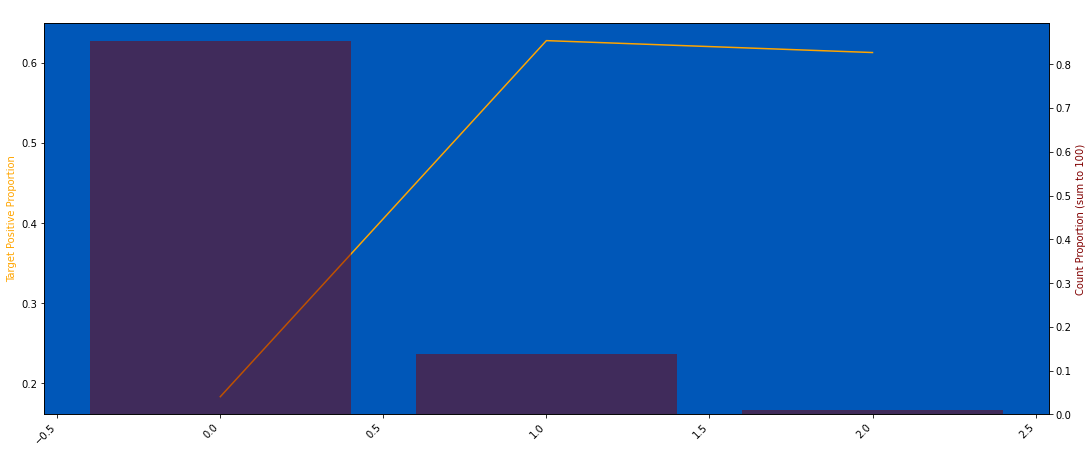

In [174]:
plot_target_check(train, "B_30", q=50, use_raw_bin=True, without_drop_tail=True)

In [175]:
# plot_train_test_distribution(df_list, "B_30", nunique_thr=8000, without_drop_tail=True)

### B_31 @Binary, Decreasing

0 null count, 0.000 null proportion
nan of the targets have label = 1


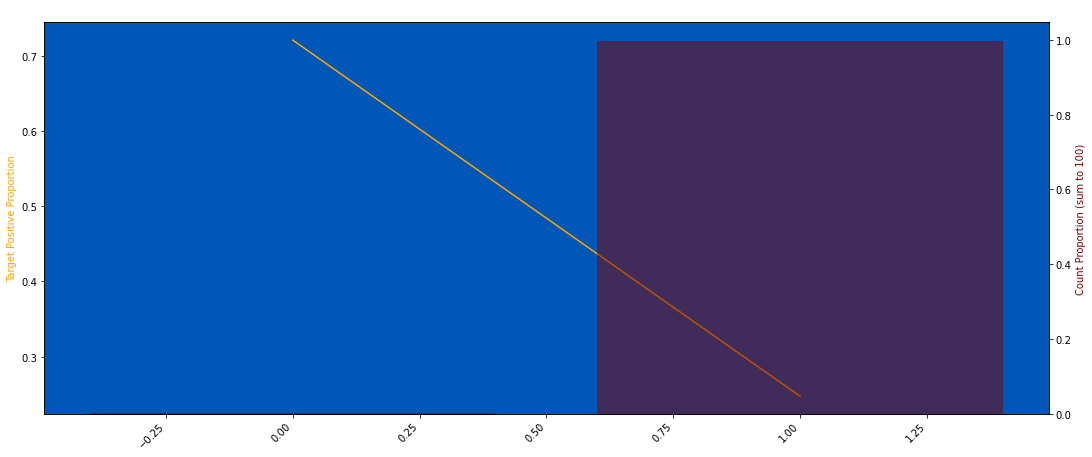

In [176]:
plot_target_check(train, "B_31", q=50, use_raw_bin=True, nunique_thr=3, without_drop_tail=True)

In [177]:
# plot_train_test_distribution(df_list, "B_31", nunique_thr=8000, without_drop_tail=True)

### B_32 @Binary, Increasing

0 null count, 0.000 null proportion
nan of the targets have label = 1


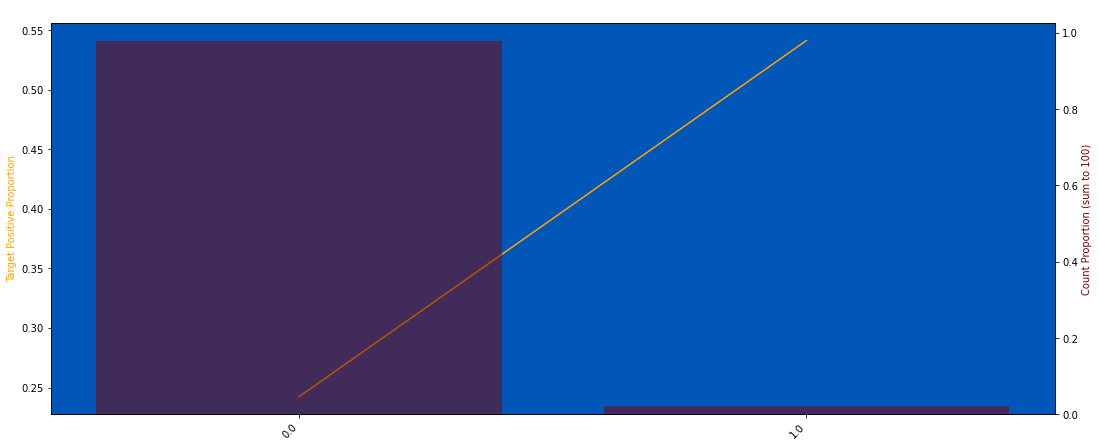

In [178]:
plot_target_check(train, "B_32", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

In [179]:
# plot_train_test_distribution(df_list, "B_32", nunique_thr=8000, without_drop_tail=True)

### B_33 @Binary, Decreasing

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


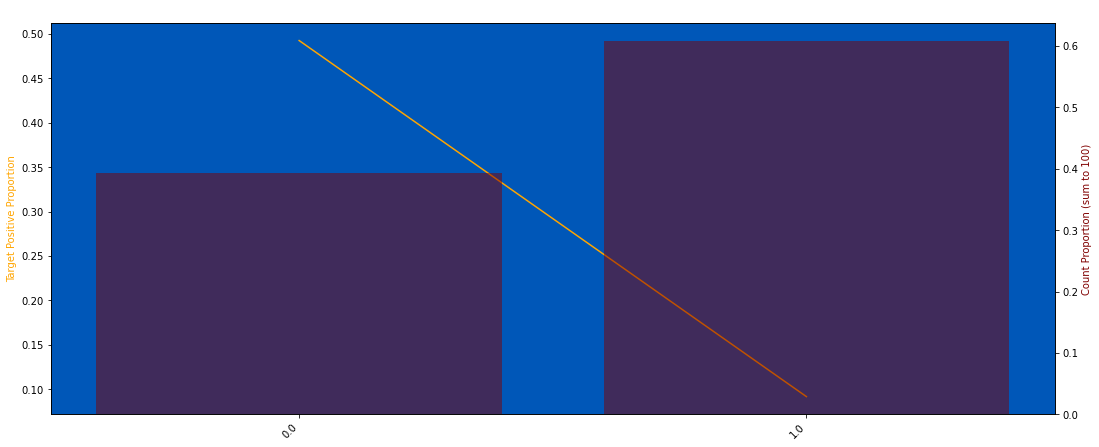

In [180]:
plot_target_check(train, "B_33", q=50, use_raw_bin=True, nunique_thr=50000, strfy_x=True, without_drop_tail=True)

In [181]:
# plot_train_test_distribution(df_list, "B_33", nunique_thr=8000, without_drop_tail=True)

### B_36 @Continuous, Increasing

In [182]:
# plot_target_check(train, "B_36", q=50, use_raw_bin=True)

In [183]:
print_percentile(df_list, "B_36", 99.95)
describe_all(df_list, "B_36")

99.95th percentile:
train : 0.47
public test : 0.48
private test : 0.5


,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0014,0.0022,0.0023
std,0.0210,0.0264,0.0274
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,1.0000,0.8300,1.1600
null_proportion,0.0000,0.0000,0.0000


In [184]:
for df in df_list:
    df = clip_col(df, "B_36", top_value=0.5, add_new_col=False)

In [185]:
for df in df_list:
    df["B_36"] = df["B_36"].replace(0, np.nan)

5500924 null count, 0.994 null proportion
0.2474 of the targets have label = 1


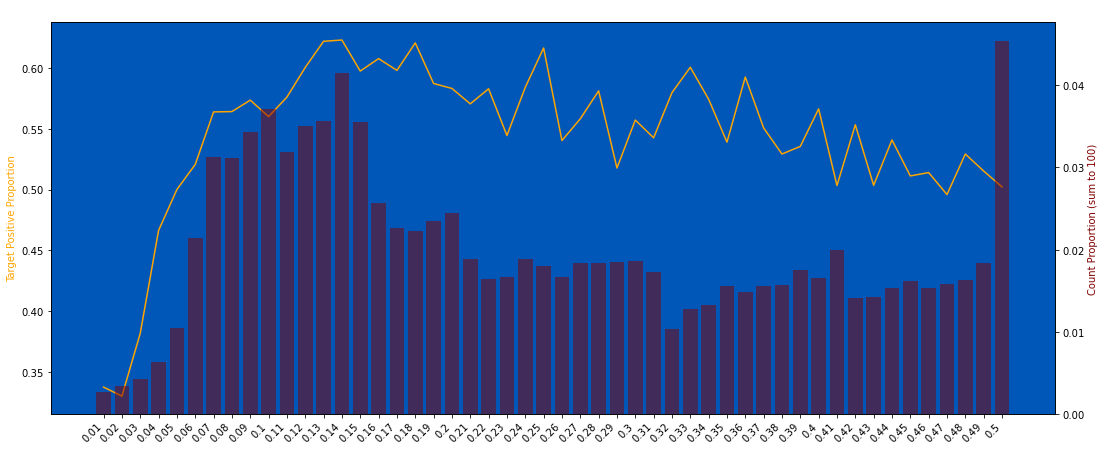

In [186]:
plot_target_check(train, "B_36", q=100, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [187]:
# plot_train_test_distribution(df_list, "B_36", nunique_thr=8000, without_drop_tail=True)

In [188]:
gc.collect()

92980

### B_37 @Continuous, Increasing

In [189]:
# plot_target_check(train, "B_37", q=50, use_raw_bin=True)

In [190]:
print_percentile(df_list, "B_37", 0.0)
describe_all(df_list, "B_37")

0.0th percentile:
train : -7.61
public test : -7.08
private test : -4.24


,train,public test,private test
count,"5,531,395.0000","5,718,424.0000","5,643,318.0000"
mean,0.1182,0.1242,0.1198
std,0.2118,0.2164,0.2099
min,-7.6100,-7.0800,-4.2400
25%,0.0000,0.0000,0.0000
50%,0.0300,0.0300,0.0300
75%,0.1200,0.1300,0.1200
max,1.3200,1.3200,1.3200
null_proportion,0.0000,0.0002,0.0002


In [191]:
for df in df_list:
    df = clip_col(df, "B_37", btm_value=-0.2, add_new_col=False)

56 null count, 0.000 null proportion
0.1964 of the targets have label = 1


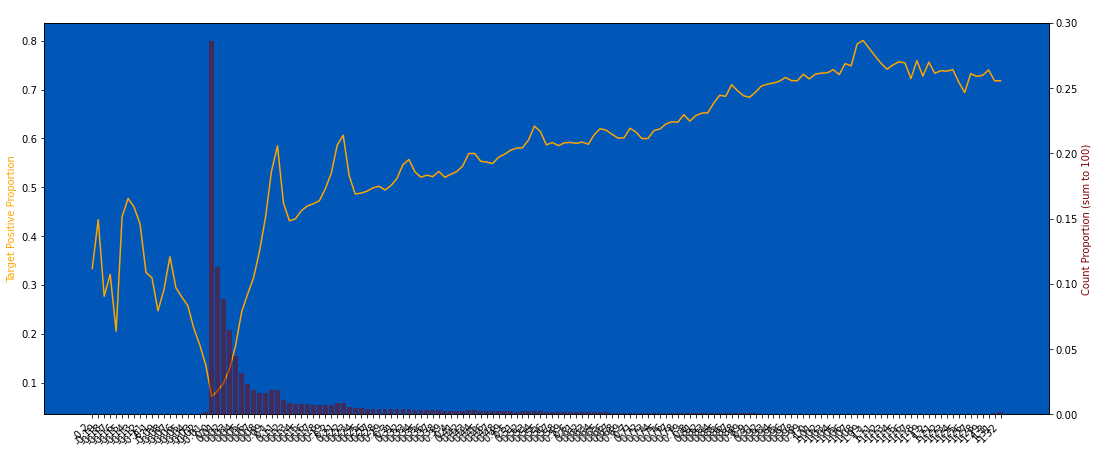

In [192]:
plot_target_check(train, "B_37", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

### B_38 @Category

In [193]:
for df in df_list:
    print(sorted(df["B_38"].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, nan]


In [194]:
mapping = dict(train.groupby(["B_38"])["target"].mean())
mapping

{1.0: 0.13526434704800755,
 2.0: 0.0633063558246025,
 3.0: 0.32860357758809544,
 4.0: 0.6997155131782841,
 5.0: 0.5594304673871995,
 6.0: 0.6149160701061467,
 7.0: 0.49886498756891146}

In [195]:
for df in df_list:
    df["B_38"] = df["B_38"].map(mapping)
    df["B_38"] = df["B_38"].astype("category").cat.codes
    df["B_38"] = df["B_38"].replace(-1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


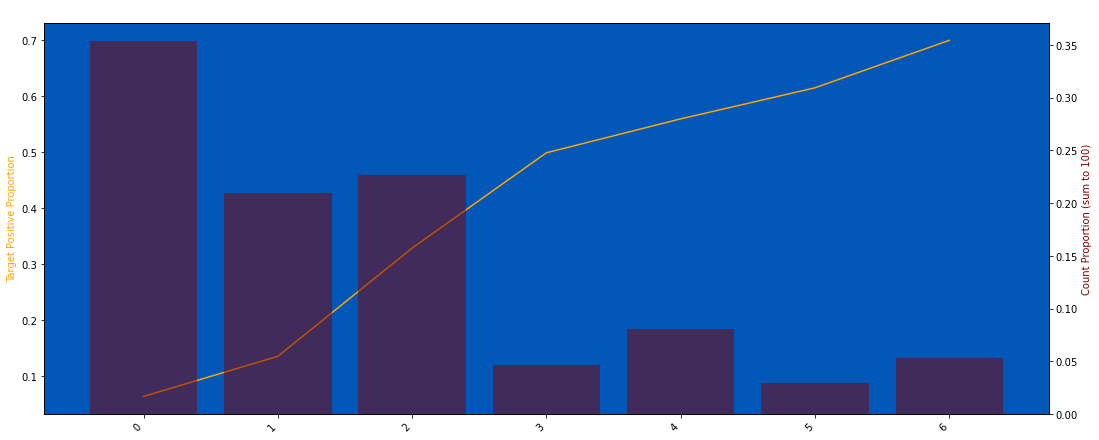

In [196]:
plot_target_check(train, "B_38", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [197]:
# plot_train_test_distribution(df_list, "B_38", nunique_thr=1000, without_drop_tail=True)

### B_39 @Continuous, Decreasing

In [198]:
# plot_target_check(train, "B_39", q=50, use_raw_bin=True)

In [199]:
print_percentile(df_list, "B_39", 0.07)
describe_all(df_list, "B_39")

0.07th percentile:
train : -0.02
public test : -0.01
private test : 0.0


,train,public test,private test
count,"33,632.0000","69,099.0000","68,492.0000"
mean,0.2505,0.4339,0.4285
std,0.2979,0.3419,0.3225
min,-0.9800,-0.0300,-0.1500
25%,0.0500,0.1500,0.1600
50%,0.1400,0.3400,0.3600
75%,0.2900,0.6700,0.6400
max,2.0600,2.8100,2.0500
null_proportion,0.9939,0.9879,0.9879


In [200]:
for df in df_list:
    df = clip_col(df, "B_39", top_value=1, add_new_col=False)
    df = clip_col(df, "B_39", btm_value=0, add_new_col=False)

5497819 null count, 0.994 null proportion
0.2473 of the targets have label = 1


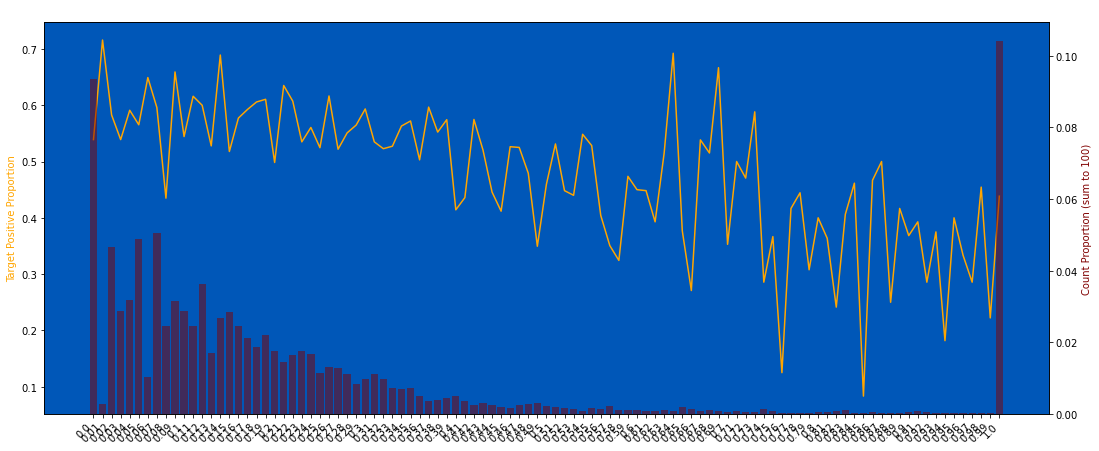

In [201]:
plot_target_check(train, "B_39", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [202]:
# plot_train_test_distribution(df_list, "B_39", nunique_thr=1000)

In [203]:
for df in df_list:
    df.drop(columns=["B_39"], errors="ignore", inplace=True)

### B_40 @Continuous, Increasing

In [204]:
# plot_target_check(train, "B_40", q=50, use_raw_bin=True)

In [205]:
print_percentile(df_list, "B_40", 99.95)
describe_all(df_list, "B_40")

99.95th percentile:
train : 6.12
public test : 5.73
private test : 5.93


,train,public test,private test
count,"5,531,398.0000","5,718,434.0000","5,643,325.0000"
mean,0.1983,0.1755,0.1821
std,8.0813,1.9339,3.7807
min,0.0000,0.0000,0.0000
25%,0.0100,0.0100,0.0100
50%,0.0500,0.0500,0.0500
75%,0.2400,0.2400,0.2300
max,"5,755.0700","2,664.2400","2,500.4800"
null_proportion,0.0000,0.0002,0.0002


In [206]:
for df in df_list:
    df = clip_col(df, "B_40", top_value=6, add_new_col=False)

53 null count, 0.000 null proportion
0.1698 of the targets have label = 1


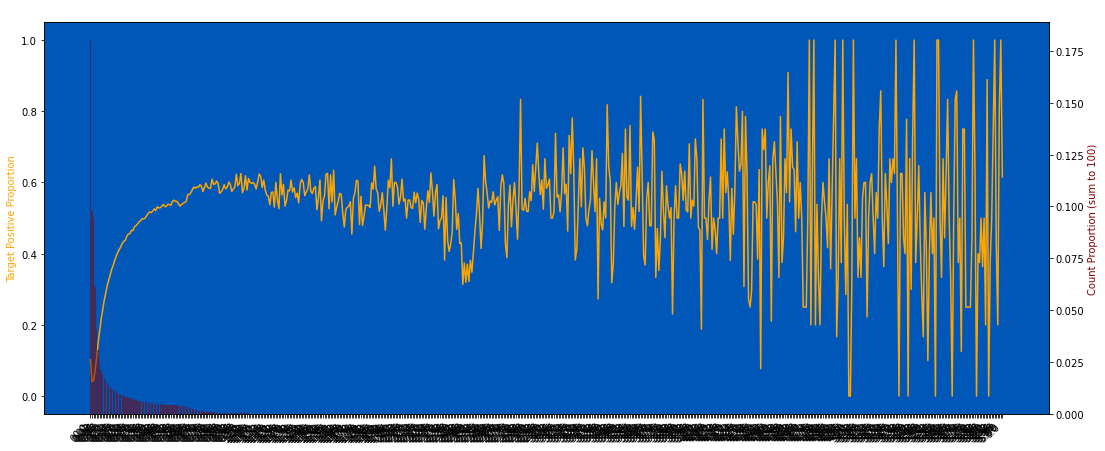

In [207]:
plot_target_check(train, "B_40", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [208]:
# plot_train_test_distribution(df_list, "B_40", nunique_thr=5000)

### B_41 @Integer, Increasing

In [209]:
# plot_target_check(train, "B_41", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [210]:
print_percentile(df_list, "B_41", 99.9)
describe_all(df_list, "B_41")

99.9th percentile:
train : 3.0
public test : 3.0
private test : 3.0


,train,public test,private test
count,"5,530,761.0000","5,717,254.0000","5,642,742.0000"
mean,0.0273,0.0309,0.0316
std,0.2223,0.2471,0.2419
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0000,0.0000,0.0000
75%,0.0000,0.0000,0.0000
max,22.0000,32.0000,24.0000
null_proportion,0.0001,0.0004,0.0003


In [211]:
for df in df_list:
    df = clip_col(df, "B_41", top_value=3, add_new_col=False)

690 null count, 0.000 null proportion
0.1420 of the targets have label = 1


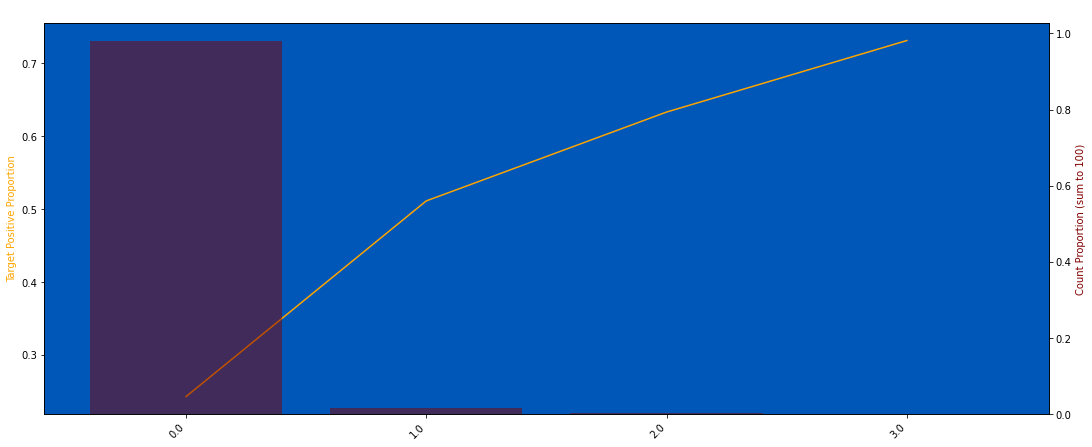

In [212]:
plot_target_check(train, "B_41", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [213]:
# plot_train_test_distribution(df_list, "B_41", nunique_thr=100, without_drop_tail=True)

### B_42

In [214]:
# plot_target_check(train, "B_42", q=50, use_raw_bin=True)

In [215]:
print_percentile(df_list, "B_42", 99.5)
describe_all(df_list, "B_42")

99.5th percentile:
train : 1.54
public test : 1.29
private test : 1.37


,train,public test,private test
count,"71,478.0000","92,388.0000","108,930.0000"
mean,0.1050,0.0947,0.0925
std,0.3137,0.2677,0.2344
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0200,0.0200,0.0200
75%,0.1000,0.0900,0.0900
max,9.0500,12.1900,7.0500
null_proportion,0.9871,0.9838,0.9807


In [216]:
for df in df_list:
    df = clip_col(df, "B_42", top_value=1.5, add_new_col=False)

5459973 null count, 0.987 null proportion
0.2508 of the targets have label = 1


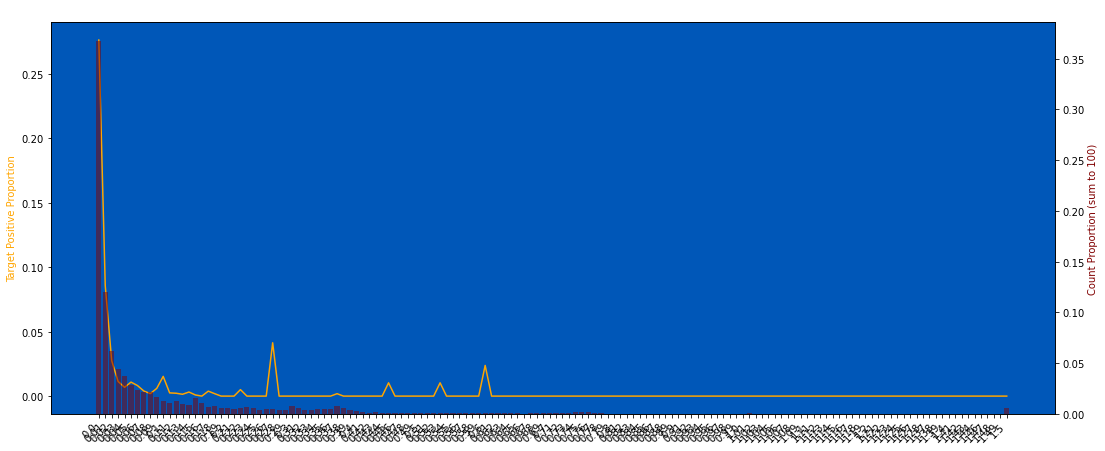

In [217]:
plot_target_check(train, "B_42", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [218]:
# plot_train_test_distribution(df_list, "B_42", nunique_thr=300)

### Column checking

In [219]:
all_columns = get_cols(df_list[0], ["B_"])
print(all_columns)

['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_40', 'B_41', 'B_42', 'B_723', 'B_111', 'B_137']


In [220]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 200].index.tolist()

In [221]:
print(less_unique_d_cols)

['B_1', 'B_2', 'B_3', 'B_4', 'B_7', 'B_8', 'B_11', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_22', 'B_23', 'B_27', 'B_30', 'B_31', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_41', 'B_42', 'B_111', 'B_137']


In [222]:
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

B_8 fulfill criteria to convert to integer
B_16 fulfill criteria to convert to integer
B_18 fulfill criteria to convert to integer
B_19 fulfill criteria to convert to integer
B_20 fulfill criteria to convert to integer
B_22 fulfill criteria to convert to integer
B_27 fulfill criteria to convert to integer
B_30 fulfill criteria to convert to integer
B_31 fulfill criteria to convert to integer
B_32 fulfill criteria to convert to integer
B_33 fulfill criteria to convert to integer
B_38 fulfill criteria to convert to integer
B_41 fulfill criteria to convert to integer


In [224]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [225]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.55s/it]

CPU times: user 793 ms, sys: 2.82 s, total: 3.61 s
Wall time: 7.67 s


In [226]:
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

B_111 fulfill criteria to convert to float32
B_137 fulfill criteria to convert to float32


### Verify if all columns have been clipped

In [227]:
for col in tqdm(df_list[0].columns):
    if col in NON_FEATURE_COLUMNS:
        continue
    if not (df_list[0][col].min() == df_list[1][col].min() == df_list[2][col].min()):
        print(f"Min of column {col} is different: {df_list[0][col].min()}, {df_list[1][col].min()}, {df_list[2][col].min()}")
    
    if not (df_list[0][col].max() == df_list[1][col].max() == df_list[2][col].max()):
        print(f"Max of column {col} is different: {df_list[0][col].max()}, {df_list[1][col].max()}, {df_list[2][col].max()}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:02<00:00, 15.72it/s]


In [228]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 4.81 s, sys: 5.49 s, total: 10.3 s
Wall time: 19.3 s


In [229]:
train.shape, test.shape

((5531451, 46), (11363762, 45))

In [230]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(1.797721591, 3.511402602)

In [231]:
%%time
train.to_parquet(f"./train_parquet/train_balance_.parquet")
test.to_parquet(f"./test_parquet/test_balance_.parquet")

CPU times: user 12.9 s, sys: 2.99 s, total: 15.9 s
Wall time: 18.2 s


In [232]:
END = time.time()

In [233]:
print(f"{END - START:.2f} seconds elapsed")

23829.74 seconds elapsed
